# Gradient Norm
Compute gradient norms and compare them among different models.

In [1]:
import numpy as np
import torch
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
from sample_batch_data import get_data_info, get_batch
from signal_propagation import get_gradients, get_gradients_grad_per_norm
from set_config import generate_variant

In [2]:
sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

## Save and Plot Gradient Norm

In [1]:
seed=666
epoch=1

torch.manual_seed(seed)

dataset_name = 'medium'
env_name = 'hopper'
path_to_model_checkpoint = 'path_to_model_checkpoint'
path_to_save_gradnorm = 'path_to_save_gradnorm'
path_to_save_figure = 'path_to_save_figure'
path_to_dataset = 'path_to_dataset'

model_names = ['gpt2', 'igpt', 'dt']

grad_norms_list = []

for model_name in model_names:

    variant = generate_variant(epoch, path_to_model_checkpoint, model_name, env_name, seed, dataset_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state_dim, act_dim, max_ep_len, scale = get_data_info(variant)
    states, actions, rewards, dones, rtg, timesteps, attention_mask = get_batch(variant, state_dim, act_dim, max_ep_len, scale, device, path_to_dataset)

    if model_name == 'igpt':
        grads_list, grad_norm_per_param = get_gradients_grad_per_norm(variant, state_dim, act_dim, max_ep_len, states, actions, rewards, rtg, timesteps, attention_mask, device)
        np.save(f'{path_to_save_gradnorm}/gradnorm_perparam_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}.npy', grad_norm_per_param)
    else:
        grads_list = get_gradients(variant, state_dim, act_dim, max_ep_len, states, actions, rewards, rtg, timesteps, attention_mask, device)

    grad_norm_list = []
    for grads in tqdm(grads_list):
        grad_norm_list.append(torch.norm(grads).numpy())
    grad_norms = np.array(grad_norm_list)
    grad_norms_list.append(grad_norms)

np.save(f'{path_to_save_gradnorm}/gradnorms_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}.npy', grad_norms_list)

model_name_label = ['GPT2', 'iGPT', 'Random Init']
colors = [(0.372, 0.537, 0.537), (0.627, 0.352, 0.470), (0.733, 0.737, 0.870)]
my_palette = sns.color_palette(colors)
sns.boxplot(data=grad_norms_list, palette=my_palette)
plt.xticks(np.arange(3), model_name_label)
plt.ylabel('Clipped Gradient Norm')
plt.ylim(top=0.25, bottom=0)
plt.savefig(f'{path_to_save_figure}/gradnorms_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}.pdf')
plt.show()

print(f'Layers with Large Gradient Norm: {sorted(grad_norm_per_param, key=grad_norm_per_param.get, reverse=True)[:2]}')
plt.figure(figsize=(20, 4))
plt.bar(x=range(len(grad_norm_per_param)), height=list(grad_norm_per_param.values()), color=colors[1], label=model_name_label[1])
plt.xlabel('Parameter of Each Layer', fontsize=20)
plt.ylabel('Clipped Gradient Norm', fontsize=20)
plt.ylim(0, 0.25)
plt.legend()
plt.tight_layout()
plt.savefig(f'{path_to_save_figure}/gradnorm_perparam_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}.pdf')
plt.show()

# Since we observe that for iGPT gradient norms of '0.ln_1.weight' and '0.ln_1.bias' are by far larger than the others, we study how much of the total is accounted for by them.
grad_norm_0ln_others = {
    '0.ln_1.weight': 0,
    '0.ln_1.bias': 0,
    'others': 0
}
total = np.sum(list(grad_norm_per_param.values()))
for key, value in grad_norm_per_param.items():
    if key == '0.ln_1.weight' or key == '0.ln_1.bias':
        grad_norm_0ln_others[key] = value / total
    else:
        grad_norm_0ln_others['others'] += value / total

total = np.sum(grad_norm_0ln_others.values())


df_others = pd.DataFrame([grad_norm_0ln_others]).astype(float)
x = np.linspace(0, 1, len(grad_norm_0ln_others))
df_others.plot.barh(stacked=True, figsize=(10, 6.7), color=[(0.372, 0.537, 0.537), (0.627, 0.352, 0.470), (0.733, 0.737, 0.870)], fontsize=20) 
plt.yticks([], [])
plt.xlim(0, 1)
plt.xlabel('Gradient Norm Ratio', fontsize=20)
plt.legend(loc="lower left", ncol=12, fontsize=20)
plt.savefig(f'{path_to_save_figure}/gradnorm_perparam_ratio_{epoch}_igpt_{env_name}_{dataset_name}_{seed}.pdf')
plt.show()

## Plot Gradient Norm

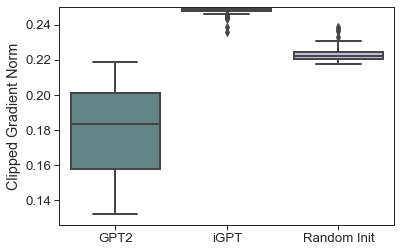

In [5]:
epoch = 1 
env_name = 'hopper'
dataset_name = 'medium'
seed = 666
path_to_gradnorm = 'path_to_gradnorm'

sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

grad_norms_list = list(np.load(f'{path_to_gradnorm}/gradnorms_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}.npy'))

model_name_label = ['GPT2', 'iGPT', 'Random Init']
colors = [(0.372, 0.537, 0.537), (0.627, 0.352, 0.470), (0.733, 0.737, 0.870)]
my_palette = sns.color_palette(colors)
sns.boxplot(data=grad_norms_list, palette=my_palette)
plt.xticks(np.arange(3), model_name_label)
plt.ylabel('Clipped Gradient Norm')
plt.ylim(top=0.25)
plt.savefig(f'{path_to_save_figure}/gradnorms_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}.pdf')
plt.show()

## Plot Gradient Norm per Parameter

Layers with Large Gradient Norm: ['0.ln_1.bias', '0.ln_1.weight']


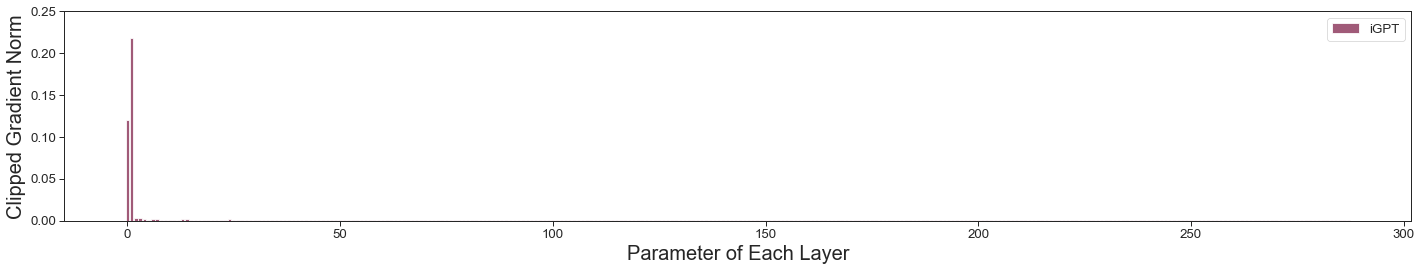

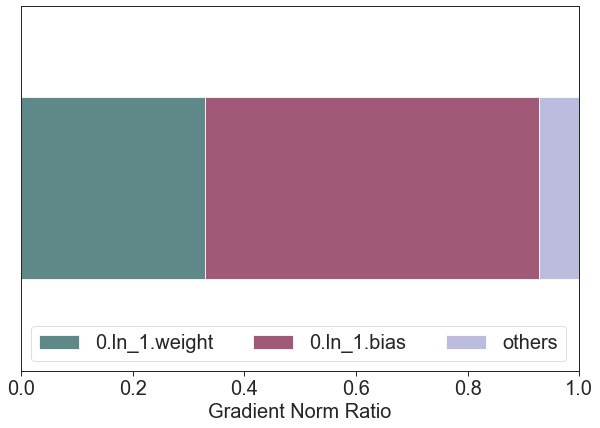

In [9]:
epoch = 1 
env_name = 'hopper'
dataset_name = 'medium'
seed = 666
model_name = 'igpt'
path_to_gradnorm = 'path_to_gradnorm'

grad_norm_per_param = np.load(f'{path_to_gradnorm}/gradnorm_perparam_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}.npy', allow_pickle=True).item()
print(f'Layers with Large Gradient Norm: {sorted(grad_norm_per_param, key=grad_norm_per_param.get, reverse=True)[:2]}')

model_name_label = ['GPT2', 'iGPT', 'Random Init']
colors = [(0.372, 0.537, 0.537), (0.627, 0.352, 0.470), (0.733, 0.737, 0.870)]
plt.figure(figsize=(20, 4))
plt.bar(x=range(len(grad_norm_per_param)), height=list(grad_norm_per_param.values()), color=colors[1], label=model_name_label[1])
plt.xlabel('Parameter of Each Layer', fontsize=20)
plt.ylabel('Clipped Gradient Norm', fontsize=20)
plt.ylim(0, 0.25)
plt.legend()
plt.tight_layout()
plt.savefig(f'{path_to_save_figure}/gradnorm_perparam_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}.pdf')
plt.show()

# Since we observe that for iGPT gradient norms of '0.ln_1.weight' and '0.ln_1.bias' are by far larger than the others, we study how much of the total is accounted for by them.
grad_norm_0ln_others = {
    '0.ln_1.weight': 0,
    '0.ln_1.bias': 0,
    'others': 0
}
total = np.sum(list(grad_norm_per_param.values()))
for key, value in grad_norm_per_param.items():
    if key == '0.ln_1.weight' or key == '0.ln_1.bias':
        grad_norm_0ln_others[key] = value / total
    else:
        grad_norm_0ln_others['others'] += value / total

total = np.sum(grad_norm_0ln_others.values())

df_others = pd.DataFrame([grad_norm_0ln_others]).astype(float)
x = np.linspace(0, 1, len(grad_norm_0ln_others))
df_others.plot.barh(stacked=True, figsize=(10, 6.7), color=[(0.372, 0.537, 0.537), (0.627, 0.352, 0.470), (0.733, 0.737, 0.870)], fontsize=20) 
plt.yticks([], [])
plt.xlim(0, 1)
plt.xlabel('Gradient Norm Ratio', fontsize=20)
plt.legend(loc="lower left", ncol=12, fontsize=20)
plt.savefig(f'{path_to_save_figure}/gradnorm_perparam_ratio_{epoch}_igpt_{env_name}_{dataset_name}_{seed}.pdf')
plt.show()